In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as manimation
from scipy.integrate import odeint
import scipy
import json
import subprocess
import os

In [2]:
def read_json(path):
    with open(path, 'r') as file:
        data = file.read()
    return json.loads(data)

def write_json(path, data):
    with open(path, 'w+') as file:
        json.dump(data, file)
        
def run_simulation(scenario, output_folder):
    cur_dir = os.path.abspath(".")
    sys_command = (
        f"java -jar {cur_dir}\\vadere-console.jar scenario-run"
        f" --scenario-file \"{cur_dir}\\{scenario}.scenario\""
        f" --output-dir=\"{cur_dir}\\outputs\\{output_folder}\""

    )
    p1 = subprocess.Popen(f"powershell.exe {sys_command}")
    p1.wait()
    #print("Process finished")
    # return last directory containing output files
    output_folders = [x[0] for x in os.walk(os.path.abspath(".") + f"\\outputs\\{output_folder}")]
    output_folders.sort()
    return output_folders[-1]

def add_ped(scenario, id, x, y, vel_x, vel_y, targetIds=[1]):
    # check if x or y is < 0 due to random noise adding
    # take abs value
    if x < 0:
        x = np.abs(x)
    if y < 0:
        y = np.abs(y)
    # add new pedestrian
    ped_dict = {
        "attributes": {
            "id": id,
            "radius": 0.2,
            "densityDependentSpeed": False,
            "speedDistributionMean": 1.34,
            "speedDistributionStandardDeviation": 0.26,
            "minimumSpeed": 0.5,
            "maximumSpeed": 2.2,
            "acceleration": 2.0,
            "footstepHistorySize": 4,
            "searchRadius": 1.0,
            "angleCalculationType": "USE_CENTER",
            "targetOrientationAngleThreshold": 45.0
        },
        "source": None,
        "targetIds": targetIds,
        "nextTargetListIndex": 0,
        "isCurrentTargetAnAgent": False,
        "position": {
            "x": x,
            "y": y
        },
        "velocity": {
            "x": vel_x,
            "y": vel_y
        },
        "freeFlowSpeed": 1.9667133893168809,
        "followers": [],
        "idAsTarget": -1,
        "isChild": False,
        "isLikelyInjured": False,
        "salientBehavior": "TARGET_ORIENTED",
        "groupIds": [],
        "trajectory": {
            "footSteps": []
        },
        "groupSizes": [],
        "modelPedestrianMap": {},
        "type": "PEDESTRIAN"
    }
    scenario["scenario"]["topography"]["dynamicElements"].append(ped_dict)
    return scenario

def reset_peds(scenario):
    scenario["scenario"]["topography"]["dynamicElements"] = []
    return scenario

def read_trajectories(file):
    traj = pd.read_csv(file, delimiter=' ')
    ped_traj = {}
    for i in range(1, n+1):
        ped_traj[i] = traj[traj['pedestrianId'] == i].reset_index()
    return ped_traj

In [13]:
def normal_draw(cov):
    """ draw an n-dimensional point from a Gaussian distribution with given 
    covariance. """
    return np.random.multivariate_normal(0*cov[:,0],cov,n).reshape(1, nd)

def observation(x):
    # relatively simple observation function z=h(x), also no change in dimension
    return x

# compute ensemble Kalman smoothing
def algorithm1_enks(z_data, error_covariance_M, error_covariance_Q, observation, fhat_model, iter_count):
    t = z_data.shape[0]
    ML = (error_covariance_M)
    QL = (error_covariance_Q)
    # initialize the initial guess for the model state with random numbers
    # normally, one would probably have a better guess
    # xk = np.random.randn(z_data.shape[0],z_data.shape[1])/10000
    # xk = np.random.uniform(0, 20, (z_data.shape[0], z_data.shape[1]))
    
    #xk = np.zeros((z_data.shape[0], z_data.shape[1]))
    # init x positions randomly between 0 and 4, (so it takes at least 20 steps to reach target)
    #xk[:, ::2] = np.random.uniform(0, 5, (z_data.shape[0], int(z_data.shape[1]/2)))
    # init y positions randomly between 0 and 20
    #xk[:, 1::2] = np.random.uniform(0, 20, (z_data.shape[0], int(z_data.shape[1]/2)))
    # since initial guess should be same as OSM init positions at timestep 0
    # other ones are recomputed anyways
    xk = z_data
    for k in range(1,t):
        zk = np.zeros((z_data.shape[1],))
        for i in range(m):
            # create corresponding output folder for debugging
            output_folder = f"enks_iter_{iter_count}_k_{k}_i_{i}"
            mkm1 = normal_draw(ML)
            # computer velocity from last timestep
            vel = (xk[k, (i*nd):((i+1)*nd)] - xk[k-1, (i*nd):((i+1)*nd)])
            xk[k,(i*nd):((i+1)*nd)] = fhat_model(xk[k-1,(i*nd):((i+1)*nd)].reshape(1,-1), vel, output_folder) + mkm1
            qk = normal_draw(QL)
            zk[(i*nd):((i+1)*nd)] = observation(xk[k,(i*nd):((i+1)*nd)].reshape(1,-1)) + qk
            # zkhat = average of  x's and y's of each ensemble (e.g. [-0.01155403  0.0435537 ])
            zkhat = 1/m*np.sum([zk[i::nd] for i in range(nd)],axis=1)
            # subtract avg from zk for each ensemble and stack in rows (.shape=(10, 2))
            zdiff = np.row_stack([(zk[(i*nd):((i+1)*nd)]-zkhat) for i in range(m)])
            Zk = np.cov(zdiff.T)
        for j in range(1,k+1):
            xjbar = np.array(1/m*np.sum([xk[j,i::nd] for i in range(nd)],axis=1))
            xdiff = np.row_stack([(xk[j,(i*nd):((i+1)*nd)]-xjbar) for i in range(m)])
            zdiff = np.row_stack([(zk[(i*nd):((i+1)*nd)]-zkhat) for i in range(m)])
            sigmaj = 1/(m-1) * (xdiff.T @ zdiff)
            matk = sigmaj @ np.linalg.pinv(Zk,rcond=1e-10)
            for i in range(m):
                xk[j,(i*nd):((i+1)*nd)] = xk[j,(i*nd):((i+1)*nd)] + matk @ (z_data[k,(i*nd):((i+1)*nd)]-zk[(i*nd):((i+1)*nd)])
    return xk

def max_likelihood(xk, fhat_model, iter_count):
    t = xk.shape[0]
    data = []
    for k in range(1, t-1):
        for i in range(m):
            output_folder = f"ml_iter_{iter_count}_k_{k}_i_{i}"
            # fhat.shape = (1, 50)
            # get velocity
            vel = xk[k, (i*nd):((i+1)*nd)] - xk[k-1, (i*nd):((i+1)*nd)]
            fhat = fhat_model(xk[k,(i*nd):((i+1)*nd)].reshape(1,-1), vel, output_folder)
            # xhat.shape = (50, )
            xhat = xk[k+1,(i*nd):((i+1)*nd)]
            data.append((xhat-fhat))
    # get average error for each pedestrian
    # TODO: check here
    data = np.row_stack(data)
    covs = [np.cov(data[:, 2*i : 2*i+2].T) for i in range(n)]
    # summing n dxd cov matrices, divide by n to get avg
    return np.sum(covs, axis=0) / (n)

In [4]:
def f_model(x, vel, output_folder):
    # x.shape = (1, 50)
    # run GNM simulation based on vector x of crowd states at any given time
    # run GNM for initial modeled data
    gnm_scenario = read_json('scenarios/GNM.scenario')
    # clear pedestrians
    gnm_scenario = reset_peds(gnm_scenario)
    # add all 25 pedestrians
    ped_id_counter = 1
    for i in range(0, x.shape[1], 2):
        gnm_scenario = add_ped(gnm_scenario, ped_id_counter, x[0, i], x[0, (i+1)], vel_x=vel[i], vel_y=vel[(i+1)])
        ped_id_counter = ped_id_counter + 1
    # save file
    write_json('scenarios/GNM.scenario', gnm_scenario)
    gnm_out_folder = run_simulation('scenarios\\GNM', output_folder)
    gnm_data = read_trajectories(gnm_out_folder + "\\postvis.traj")
    # get only first values for each ped representing the current time step
    # for each ped end{X|Y}-PID1 is where ped ends up after one timestep evolving
    x = np.array([(gnm_data[i]['endX-PID1'][0], gnm_data[i]['endY-PID1'][0]) for i in range(1, n+1)])
    return np.column_stack([x[int(i/m)].reshape(1, -1) for i in range(n)])

In [5]:
# Initial state of the true and simulated data
x0 = np.array([1,0]).reshape(1,-1)
x0 = x0 / np.linalg.norm(x0)    # x0.shape = (1, 2)

In [6]:
random_seed = 1 # used throughout the example
np.random.seed(random_seed)
NT = 40
model_error = 1e-1
true_error = 1e-4

m = 3 # ensemble runs
n = 30
d = 2
nd = n*d # total state dimension = 50

xt = np.zeros((NT, (nd*m))) # xt.shape = (20, 500)
# initialize the ensembles with randomly perturbed states
xt[0,:] = np.column_stack([x0+np.random.uniform(0, 20) for i in range(m*n)])
xm = xt.copy()   # xm.shape = (20, 500)

In [7]:
# get init data from simulation
# Read OSM trajectories for true data
osm_data = read_trajectories('output/OSM_real_data_30/postvis.traj')

In [8]:
# run GNM for initial modeled data
gnm_scenario = read_json('scenarios/GNM.scenario')
gnm_scenario = reset_peds(gnm_scenario)
# add all pedestrians
for i in range(n):
    vel_x = osm_data[i+1]['endX-PID1'][0] - osm_data[i+1]['startX-PID1'][0]
    vel_y = osm_data[i+1]['endY-PID1'][0] - osm_data[i+1]['endY-PID1'][0]
    gnm_scenario = add_ped(gnm_scenario, i+1, osm_data[i+1]['startX-PID1'][0], osm_data[i+1]['startY-PID1'][0], 
                           vel_x, vel_y)
# save file
write_json('scenarios/GNM.scenario', gnm_scenario)
gnm_out_folder = run_simulation('scenarios\\GNM', 'temp')
gnm_data = read_trajectories(gnm_out_folder + "\\postvis.traj")

In [9]:
# initialize the ensembles with randomly perturbed states for xt
for t in range(0, NT):
    x = np.array([(osm_data[i]['startX-PID1'][t], osm_data[i]['startY-PID1'][t]) for i in range(1, n+1)])
    xt[t, :] = np.column_stack([x[int(i/m)].reshape(1, -1)+np.random.randn(1)/1000 for i in range(m*n)])
    x = np.array([(gnm_data[i]['startX-PID1'][t], gnm_data[i]['startY-PID1'][t]) for i in range(1, n+1)])
    xm[t, :] = np.column_stack([x[int(i/m)].reshape(1, -1)+np.random.randn(1)/1000 for i in range(m*n)])

Text(0.5, 1.0, 'trajectories in time')

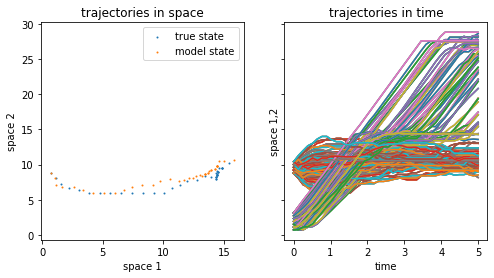

In [10]:
T = 5
time = 10
time = np.linspace(0,T,NT)
fig,ax = plt.subplots(1,2,figsize=(8,4),sharey=True)
ax[0].scatter(xt[:,2], xt[:,3],s=1,label='true state')
ax[0].scatter(xm[:,2], xm[:,3],s=1, label='model state')
ax[0].set_xlabel('space 1')
ax[0].set_ylabel('space 2')
ax[0].set_title('trajectories in space')
ax[0].legend()
ax[1].plot(time,xt);
ax[1].plot(time,xm);
ax[1].set_xlabel('time')
ax[1].set_ylabel('space 1,2')
ax[1].set_title('trajectories in time')

In [11]:
# this is the initial guess for the entropy matrix. can be pretty arbitrary
M = np.identity(d)  # M.shape = (25, 25)
# this is the guess for the true error in the observations. should be small here.
Q = np.identity(d) * true_error**2   # Q.shape = (25, 25)
N_ITER = 3 # number of iterations of algorithm1_enks and max_likelihood
Mhat = M   # Mhat.shape = (25, 25)
xm_hat = 0
xm_hat_prev = 0

In [ ]:
for k in range(N_ITER):
    # initialize with randomly pertubated states for each run
    for t in range(0, NT):
        x = np.array([(osm_data[i]['startX-PID1'][t], osm_data[i]['startY-PID1'][t]) for i in range(1, n+1)])
        xt[t, :] = np.column_stack([x[int(i/m)].reshape(1, -1)+np.random.randn(1)/1000 for i in range(m*n)])
    zk = observation(xt)
    xm_hat = algorithm1_enks(zk, Mhat, Q, observation, f_model, k);
    Mhat = max_likelihood(xm_hat, f_model, k)
    print('current det(M)', np.linalg.det(Mhat))
    print('error change ', np.linalg.norm(xm_hat - xm_hat_prev))
    xm_hat_prev = xm_hat

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,4),sharey=True)
ax[0].plot(time, xt[:,0],label='true state 1');
ax[0].plot(time, xt[:,1],label='true state 2');
ax[0].plot(time[1:], zk[:,0],'g:',label='observation 1');
ax[0].plot(time[1:], zk[:,1],'g.',label='observation 2');
ax[0].set_title('true states and observations')
ax[0].legend()
# this second plot shows the estimated MODEL (!) state, but since the model here is just the truth plus noise,
# the estimated model state should be the true state.
# We also skip the first state in xm_hat, since it was chosen at random.
ax[1].plot(time[2:], xm_hat[1:,0],'-',label='estimated model state 1');
ax[1].plot(time[2:], xm_hat[1:,1],'-',label='estimated model state 2');
ax[1].set_title('estimated states from observations and model')
ax[1].legend();

In [ ]:
def entropy(M):
    return 1/2 * n * np.log((2*np.pi*np.exp(1))**d * np.linalg.det(M))
# print the estimated entropy against the known entropy.
# this is only possible in this computational experiment, because we normally 
# do not know the 'true model' and the model error.
print('entropy(M estimated) ', entropy(Mhat*n))

In [ ]:
data = Mhat

In [ ]:
data.shape

In [ ]:
Mhat.shape

In [ ]:
np.linalg.det(Mhat)

In [ ]:
Mhat